In [1]:
# !pip install pmdarima -t /home/aistudio/external-libraries/pmdarima

In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries/chinese_calendar')
sys.path.append('/home/aistudio/external-libraries/statsmodels')
sys.path.append('/home/aistudio/external-libraries/plotly')
sys.path.append('/home/aistudio/external-libraries/pmdarima')

In [2]:
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import gc

from datetime import date
from datetime import timedelta
import chinese_calendar

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

### 仪表能耗

In [3]:
# 仪表能耗
meter_daily = pd.read_csv(r"./data/data141580/仪表每天能耗数据.csv", encoding='utf-16')

In [4]:
###############能耗数据预处理

In [5]:
# meter_daily[meter_daily['meter'] == 11275]['data_time'].apply(lambda x: pd.to_datetime(x, format="%Y%m%d000000"))
meter_daily['date'] = meter_daily['data_time'].apply(lambda x: pd.to_datetime(x, format="%Y%m%d000000"))

In [6]:
# check_day = '2022-04-24'
# [int(t) for t in check_day.split('-')]
# check_day = date(*[int(t) for t in check_day.split('-')])

# chinese_calendar.is_holiday(check_day), chinese_calendar.is_in_lieu(check_day), chinese_calendar.is_workday(check_day)

In [8]:
meter_daily[meter_daily['meter'] == 11275]

,meter,meter_name,meter_function_explain,energy_item_id,c_name,data_time,data_value,c_order,date
0,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20210801000000,0.0,4,2021-08-01
1,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20210802000000,0.0,4,2021-08-02
2,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20210803000000,0.0,4,2021-08-03
3,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20210804000000,0.0,4,2021-08-04
4,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20210805000000,0.0,4,2021-08-05
...,...,...,...,...,...,...,...,...,...
238,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20220327000000,0.0,4,2022-03-27
239,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20220328000000,0.0,4,2022-03-28
240,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20220329000000,0.0,4,2022-03-29
241,11275,8D1/6-4 弱电安防系统预留（备）,正向有功电能二次侧,EI101030410001,信息机房（办公）,20220330000000,0.0,4,2022-03-30


In [9]:
meter_daily.sort_values(by=['date', 'energy_item_id', 'meter'], inplace=True)

In [10]:
# df_meter_daily = meter_daily.pivot(index=['meter'], 
#                          columns=['date'], values=['data_value'])

df_meter_daily = meter_daily.pivot(index=['meter', 'meter_name', 'meter_function_explain',
                         'energy_item_id', 'c_name', 'c_order'], 
                         columns=['date'], values=['data_value'])

In [11]:
cols = df_meter_daily.columns.droplevel(0)
df_meter_daily.columns = cols

In [12]:
df_meter_daily

,,,,,date,2021-08-01,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-08-09,2021-08-10,...,2022-03-22,2022-03-23,2022-03-24,2022-03-25,2022-03-26,2022-03-27,2022-03-28,2022-03-29,2022-03-30,2022-03-31
meter,meter_name,meter_function_explain,energy_item_id,c_name,c_order,,,,,,,,,,,,,,,,,,,,,
10835,3D1/4 租户负荷1（L1-L2）,正向有功电能二次侧,EI5201314064,租户负荷,68,2274.008180,2054.573487,2053.895,2097.965526,2095.131140,2088.018333,2280.371667,2327.255633,2092.410785,2083.216539,...,1962.021905,1936.106667,1857.368919,2013.378378,2331.840634,2345.592504,1915.534081,1961.076679,1905.766532,2001.710130
10836,3D1/5 租户负荷2（B1）,正向有功电能二次侧,EI5201314064,租户负荷,68,1721.587533,1690.182467,1633.450,1685.617105,1640.766228,1745.836667,1794.950000,1789.009734,1733.221017,1727.022824,...,1777.585065,1767.235714,1675.224675,1761.431818,1834.511364,1839.508333,1720.230952,1637.563700,1750.060399,1784.904949
10837,3D1/6-1 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10838,3D1/6-2 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10839,3D1/6-3 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,10D2/8-5 擦窗机（备用）,正向有功电能二次侧,EI5201314075,擦窗机（办公）,45,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11575,10D2/8-4 弱电间,正向有功电能二次侧,EI5201314023,信息机房（办公）,34,40.049736,39.928597,40.000,39.800000,40.158333,40.053333,40.188333,40.014065,39.820281,39.935453,...,36.536277,36.206230,36.220717,36.063802,35.516183,35.508097,36.843578,35.873924,36.823192,35.760283
11576,10D1/10-1 消防水泵（备）,正向有功电能二次侧,EI5201314027,消防水泵（办公）,37,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
val_list = df_meter_daily.values.reshape(-1).tolist()

val_list.sort()
val_set = set(val_list)

val_list = list(val_set)

val_list.sort()
val_list

[0.0,
 0.000831028414,
 0.001,
 0.001008057476,
 0.001417626775,
 0.001570225575,
 0.001820539831,
 0.0036830770429999997,
 0.003715846976,
 0.0042345187410000006,
 0.004315524476,
 0.00765029853,
 0.00841269842,
 0.008502024290999999,
 0.011315612089,
 0.013393651373999999,
 0.015389166969000001,
 0.015956513476,
 0.016666666667,
 0.017989158729,
 0.018574978639,
 0.020385602561999998,
 0.020765027321999998,
 0.021132996390999997,
 0.021417142048,
 0.021548013175,
 0.025238095260999998,
 0.027268871843,
 0.028031754814,
 0.028091938284,
 0.02936386279,
 0.029783722005,
 0.030000000027000002,
 0.03092149654,
 0.035571875894,
 0.03628392046,
 0.03714583131,
 0.03748811773,
 0.037694429688,
 0.037893562339,
 0.037988357241000005,
 0.039036682967,
 0.039405165140999995,
 0.041330519706000005,
 0.041835786045,
 0.043898181807,
 0.047792665413,
 0.048158665832,
 0.05184133417,
 0.053638856383,
 0.057654556739999994,
 0.058481344289999994,
 0.059588606599000005,
 0.060449026685,
 0.060954282

In [14]:
# 平滑数据
factor = 1.5
upper_limit = (df_meter_daily.mean(axis=1) + df_meter_daily.std(axis=1) * factor).reset_index(drop=True)
lower_limit = (df_meter_daily.mean(axis=1) - df_meter_daily.std(axis=1) * factor).reset_index(drop=True)

In [15]:
# df_meter_daily.T.plot(subplots = True, figsize = (15,500))
# [ax.legend(loc = 1) for ax in plt.gcf().axes]

# .set_index('Dates')[['PGE', 'SCE', 'SDGE', 'VEA', 'CAISO Total']].plot(subplots = True, figsize = (12,7))
# [ax.legend(loc = 1) for ax in plt.gcf().axes]

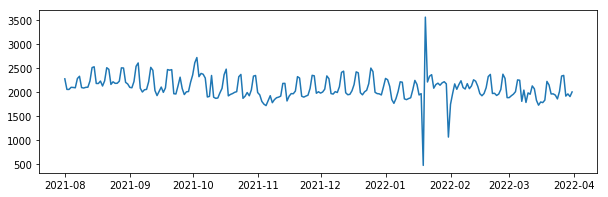

In [16]:
plt.figure(figsize=(10,3))
plt.clf();
plt.ion()
plt.plot(df_meter_daily.iloc[0])
# plt.plot(df_meter_daily[df_meter_daily.index.droplevel((1,2,3,4,5)) == 10952].T)

In [17]:
def smooth_data(value):
    # print(value)
    # print(type(value))

    # print('------------------------------')

    return(\
    value * ((value <= upper_limit) & (value >= lower_limit))\
    + upper_limit * (value > upper_limit)\
    + lower_limit * (value < lower_limit)\
    )


In [18]:
# df_meter_daily.reset_index(drop=True)[['2021-08-01']].apply(lambda x: smooth_data(x)).values

In [19]:
for col in df_meter_daily.columns:
    df_meter_daily.loc[:, col] = df_meter_daily.reset_index(drop=True)[[col]]\
                                               .apply(lambda x : smooth_data(x)).values

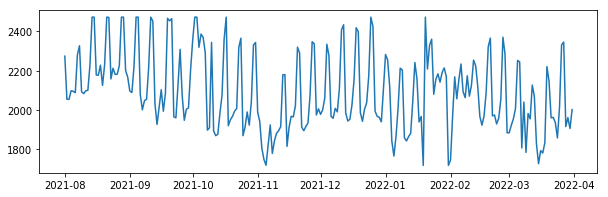

In [20]:
plt.figure(figsize=(10,3))
plt.clf();
plt.ion()
plt.plot(df_meter_daily.iloc[0])
# plt.plot(df_meter_daily[df_meter_daily.index.droplevel((1,2,3,4,5)) == 10952].T)

In [21]:
# low_filter = 0.5

In [22]:
# for col in df_meter_daily.columns:
#     df_meter_daily.loc[:, col] = (df_meter_daily[col] > low_filter) * df_meter_daily[col]

In [23]:
df_meter_daily.fillna(0.0001, inplace=True)

In [24]:
# 导出数据
df_meter_daily.to_pickle('./work/AI_data/df_meter_daily.pkl')

### 日期数据

In [43]:
n_steps = 21
focst_steps = 7

open_date = pd.to_datetime("2021-04-23")

In [44]:
min_date, max_date = meter_daily['date'].min(), meter_daily['date'].max()
min_date, max_date

(Timestamp('2021-08-01 00:00:00'), Timestamp('2022-03-31 00:00:00'))

In [45]:
max_date = pd.to_datetime('2022-4-30')
max_date

Timestamp('2022-04-30 00:00:00')

In [46]:
df_dates = pd.DataFrame(pd.date_range(min_date, max_date, freq='D'), columns=['date'])
df_dates

,date
0,2021-08-01
1,2021-08-02
2,2021-08-03
3,2021-08-04
4,2021-08-05
...,...
268,2022-04-26
269,2022-04-27
270,2022-04-28
271,2022-04-29


In [47]:
# 日期特征工程
# 当天
df_dates['date_year'] = df_dates['date'].dt.year#.astype('category')
df_dates['date_month'] = df_dates['date'].dt.month#.astype('category')
df_dates['date_day'] = df_dates['date'].dt.day#.astype('category')
df_dates['date_week'] = df_dates['date'].dt.week#.astype('category')
df_dates['date_dayofweek'] = df_dates['date'].dt.dayofweek#.astype('category')
df_dates['date_dayofyear'] = df_dates['date'].dt.dayofyear
df_dates['date_is_holiday'] = df_dates['date'].apply(lambda x:chinese_calendar.is_holiday(x))
df_dates['date_is_in_lieu'] = df_dates['date'].apply(lambda x:chinese_calendar.is_in_lieu(x))
df_dates['date_is_workday'] = df_dates['date'].apply(lambda x:chinese_calendar.is_workday(x))
df_dates['date_is_dayoff'] = np.logical_or(df_dates['date_is_holiday'], df_dates['date_is_in_lieu'])

df_dates['date_diff'] = df_dates['date'].apply(lambda x: (x - open_date).days)

df_dates = pd.get_dummies(df_dates, drop_first = True)

In [48]:
df_dates.head(2)

,date,date_year,date_month,date_day,date_week,date_dayofweek,date_dayofyear,date_is_holiday,date_is_in_lieu,date_is_workday,date_is_dayoff,date_diff
0,2021-08-01,2021,8,1,30,6,213,True,False,False,True,100
1,2021-08-02,2021,8,2,31,0,214,False,False,True,False,101


In [49]:
# 添加未来日期的特征
for i in range(focst_steps):
    # 未来第i 天
    d = i + 1
    df_dates['future' + str(d) + 'days'] = df_dates['date'] + timedelta(days = d)

    # 未来第7天
    df_dates['future' + str(d) + 'days_year'] = df_dates['future' + str(d) + 'days'].dt.year
    df_dates['future' + str(d) + 'days_month'] = df_dates['future' + str(d) + 'days'].dt.month
    df_dates['future' + str(d) + 'days_day'] = df_dates['future' + str(d) + 'days'].dt.day
    df_dates['future' + str(d) + 'days_week'] = df_dates['future' + str(d) + 'days'].dt.week
    df_dates['future' + str(d) + 'days_dayofweek'] = df_dates['future' + str(d) + 'days'].dt.dayofweek
    df_dates['future' + str(d) + 'days_dayofyear'] = df_dates['future' + str(d) + 'days'].dt.dayofyear
    df_dates['future' + str(d) + 'days_is_holiday'] = df_dates['future' + str(d) + 'days'].apply(lambda x:chinese_calendar.is_holiday(x))
    df_dates['future' + str(d) + 'days_is_in_lieu'] = df_dates['future' + str(d) + 'days'].apply(lambda x:chinese_calendar.is_in_lieu(x))
    df_dates['future' + str(d) + 'days_is_workday'] = df_dates['future' + str(d) + 'days'].apply(lambda x:chinese_calendar.is_workday(x))
    df_dates['future' + str(d) + 'days_is_dayoff'] = np.logical_or(df_dates['future' + str(d) + 'days_is_holiday'], df_dates['future' + str(d) + 'days_is_in_lieu'])

    df_dates['future' + str(d) + 'days_diff'] = df_dates['future' + str(d) + 'days'].apply(lambda x: (x - open_date).days)

    df_dates.drop(['future' + str(d) + 'days'], axis=1 , inplace=True)

In [50]:
df_dates = df_dates.set_index('date')

In [51]:
df_dates

,date_year,date_month,date_day,date_week,date_dayofweek,date_dayofyear,date_is_holiday,date_is_in_lieu,date_is_workday,date_is_dayoff,...,future7days_month,future7days_day,future7days_week,future7days_dayofweek,future7days_dayofyear,future7days_is_holiday,future7days_is_in_lieu,future7days_is_workday,future7days_is_dayoff,future7days_diff
date,,,,,,,,,,,,,,,,,,,,,
2021-08-01,2021,8,1,30,6,213,True,False,False,True,...,8,8,31,6,220,True,False,False,True,107
2021-08-02,2021,8,2,31,0,214,False,False,True,False,...,8,9,32,0,221,False,False,True,False,108
2021-08-03,2021,8,3,31,1,215,False,False,True,False,...,8,10,32,1,222,False,False,True,False,109
2021-08-04,2021,8,4,31,2,216,False,False,True,False,...,8,11,32,2,223,False,False,True,False,110
2021-08-05,2021,8,5,31,3,217,False,False,True,False,...,8,12,32,3,224,False,False,True,False,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,2022,4,26,17,1,116,False,False,True,False,...,5,3,18,1,123,True,True,False,True,375
2022-04-27,2022,4,27,17,2,117,False,False,True,False,...,5,4,18,2,124,True,True,False,True,376
2022-04-28,2022,4,28,17,3,118,False,False,True,False,...,5,5,18,3,125,False,False,True,False,377


In [52]:
# 导出数据
df_dates.to_pickle('./work/AI_data/df_dates.pkl')